## Introduction: 
- Briefly explain the goal of the assignment 
- the concept of Beta-VAE.

### Goal of Assignment:
The goal of this assignment is to understand and emplement a ß-VAE model on the celebA data set and see how it preform. As well as to do result anaysis for the recosntrued images, latent space traversals, and loss curves. In addition to grasping an understanding of how β influences the disentanglement and reconstruction quality in the context of the celebA dataset.

### The Concept of ß-VAE:
The β-VAE model extends the traditional Variational Autoencoder (VAE) by introducing an additional hyperparameter, β. Unlike a standard VAE, which primarily focuses on reconstructing the input data accurately, β-VAE balances this reconstruction with the disentanglement of latent variables. In a VAE, the encoder outputs parameters defining a distribution—specifically, the mean and variance—from which latent variables are sampled. The reparameterization trick is employed to standardize these outputs, centering the mean at 0 and the variance at 1, to stabilize training. The hyperparameter β modifies the loss function to weigh the KL divergence term, which encourages the latent variables to be independent and informative about the data. A higher β places greater emphasis on disentangling these latent variables at the expense of reconstruction accuracy, promoting the separation of underlying data factors into distinct latent dimensions. Conversely, a lower β, closer to the traditional VAE's value of 1, favors accurate reconstruction over disentanglement, leading to more blended latent representations but better visual similarity in reconstructions.

## Data Preparation:
 - Show how you downloaded and prepared the CelebA dataset.


In [1]:
! pip install pytorch-lightning
! pip install --upgrade torch transformers


In [1]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations and data loading
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),
])

# Assuming you are using a dataset that fits the use of such transforms
train_dataset = datasets.ImageFolder(root='/Users/lancesanterre/msds2023/summer_2/hw1/PyTorch-VAE/--VAE_CELEBA/celeba/', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=3, pin_memory=True)
# If you have validation data
val_dataset = datasets.ImageFolder(root='/Users/lancesanterre/msds2023/summer_2/hw1/PyTorch-VAE/--VAE_CELEBA/celeba/', transform=transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True, num_workers=3, pin_memory=True)


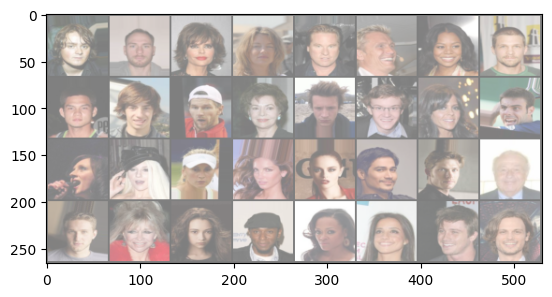

Shape of the images batch: torch.Size([32, 3, 64, 64])


In [2]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and print the shape of the tensor
imshow(make_grid(images))
print("Shape of the images batch:", images.shape)

In [4]:
import time

for num_workers in [0,1,2,3,4,5,6,7,8]:
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    start_time = time.time()
    for i, data in enumerate(train_loader):
        
        pass
    end_time = time.time()

    print(f"Num Workers: {num_workers}, Time taken: {end_time - start_time:.2f} seconds")


Num Workers: 0, Time taken: 124.69 seconds
Num Workers: 1, Time taken: 101.39 seconds
Num Workers: 2, Time taken: 60.78 seconds
Num Workers: 3, Time taken: 51.28 seconds
Num Workers: 4, Time taken: 49.72 seconds
Num Workers: 5, Time taken: 55.89 seconds
Num Workers: 6, Time taken: 59.13 seconds
Num Workers: 7, Time taken: 63.11 seconds
Num Workers: 8, Time taken: 70.37 seconds


In [5]:
train_dataset = datasets.ImageFolder(root='/Users/lancesanterre/msds2023/summer_2/hw1/PyTorch-VAE/data/celeba/', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

# If you have validation data
val_dataset = datasets.ImageFolder(root='/Users/lancesanterre/msds2023/summer_2/hw1/PyTorch-VAE/data/celeba/', transform=transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

## Training: 
- Include the code to train the Beta-VAE model. Use the main.py script provided in the repository.


In [6]:
from models import BetaVAE  # Ensure your model file is named correctly

# Initialize model
model = BetaVAE(in_channels=3, latent_dim=10).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        results = model(data)
        loss_outputs = model.loss_function(*results,
                                            M_N=1.0/len(data_loader.dataset), # Adjust M_N as required
                                            device=device)
        
        # Extract loss and backpropagate
        loss = loss_outputs['loss']
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    # Average loss across all batches
    train_loss /= len(data_loader)
    return train_loss


In [8]:
def validate_epoch(model, data_loader, device):
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            
            # Forward pass
            results = model(data)
            loss_outputs = model.loss_function(*results,
                                                M_N=1.0/len(data_loader.dataset), # Adjust M_N as required
                                                device=device)
            
            # Extract loss
            loss = loss_outputs['loss']
            validation_loss += loss.item()

    # Average loss across all validation data
    validation_loss /= len(data_loader)
    return validation_loss


In [9]:
num_epochs = 15  # Define the number of epochs

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = validate_epoch(model, val_loader, device)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save model periodically or based on performance
    torch.save(model.state_dict(), 'beta_vae_checkpoint.pth')


Epoch 1, Train Loss: 0.0537, Val Loss: 0.0462
Epoch 2, Train Loss: 0.0385, Val Loss: 0.0390
Epoch 3, Train Loss: 0.0317, Val Loss: 0.0340
Epoch 4, Train Loss: 0.0279, Val Loss: 0.0287
Epoch 5, Train Loss: 0.0253, Val Loss: 0.0286
Epoch 6, Train Loss: 0.0237, Val Loss: 0.0261
Epoch 7, Train Loss: 0.0228, Val Loss: 0.0257
Epoch 8, Train Loss: 0.0222, Val Loss: 0.0254
Epoch 9, Train Loss: 0.0219, Val Loss: 0.0228
Epoch 10, Train Loss: 0.0218, Val Loss: 0.0225
Epoch 11, Train Loss: 0.0216, Val Loss: 0.0222
Epoch 12, Train Loss: 0.0215, Val Loss: 0.0223
Epoch 13, Train Loss: 0.0214, Val Loss: 0.0221
Epoch 14, Train Loss: 0.0214, Val Loss: 0.0219
Epoch 15, Train Loss: 0.0213, Val Loss: 0.0222


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def validate_and_visualize_epoch(model, data_loader, device, num_images=10):
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            
            # Forward pass to get outputs and calculate loss
            results = model(data)
            recons = results[0]
            loss_outputs = model.loss_function(*results,
                                                M_N=1.0/len(data_loader.dataset),
                                                device=device)
            loss = loss_outputs['loss']
            validation_loss += loss.item()

            if batch_idx == 0:  # Just visualize the first batch
                # Move images and reconstructions to CPU for visualization
                data = data.to('cpu')
                recons = recons.to('cpu')
                
                # Plotting
                fig, axs = plt.subplots(2, num_images, figsize=(15, 4))
                for i in range(num_images):
                    # Display original images
                    axs[0, i].imshow(data[i].permute(1, 2, 0))
                    axs[0, i].title.set_text('Original')
                    axs[0, i].axis('off')

                    # Display reconstructed images
                    axs[1, i].imshow(recons[i].permute(1, 2, 0))
                    axs[1, i].title.set_text('Reconstructed')
                    axs[1, i].axis('off')

                plt.show()

    validation_loss /= len(data_loader)
    return validation_loss


In [11]:


def visualize_2d_latent_traversals(model, device, dim_range=2, num_samples=10, latent_dim=10, dims_to_traverse=(0, 1)):
    model.eval()
    with torch.no_grad():
        # Generate a grid of latent vectors
        lin_spaces = [torch.linspace(-dim_range, dim_range, num_samples) for _ in range(2)]
        grid_x, grid_y = torch.meshgrid(lin_spaces[0], lin_spaces[1], indexing='ij')
        z = torch.zeros(num_samples * num_samples, latent_dim).to(device)  # Flatten grid for batch processing

        # Adjust the shape of grid_x and grid_y to match the expected shape for assignment
        grid_x_flat = grid_x.flatten()
        grid_y_flat = grid_y.flatten()

        # Assign values from grid_x and grid_y to the specified dimensions in z
        z[:, dims_to_traverse[0]] = grid_x_flat
        z[:, dims_to_traverse[1]] = grid_y_flat

        # Decode the latent vectors
        reconstructions = model.decode(z).to('cpu')
        reconstructions = reconstructions.view(num_samples, num_samples, *reconstructions.shape[1:])

        # Plotting
        fig, axs = plt.subplots(num_samples, num_samples, figsize=(15, 15))
        for i in range(num_samples):
            for j in range(num_samples):
                axs[i, j].imshow(reconstructions[i, j].permute(1, 2, 0))
                axs[i, j].axis('off')
                if i == 0:
                    axs[i, j].set_title(f'y: {lin_spaces[1][j]:.2f}')
                if j == 0:
                    axs[i, j].set_ylabel(f'x: {lin_spaces[0][i]:.2f}')
        
        plt.show()


In [12]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_loss_curves(train_loss, validation_loss)


NameError: name 'validation_loss' is not defined

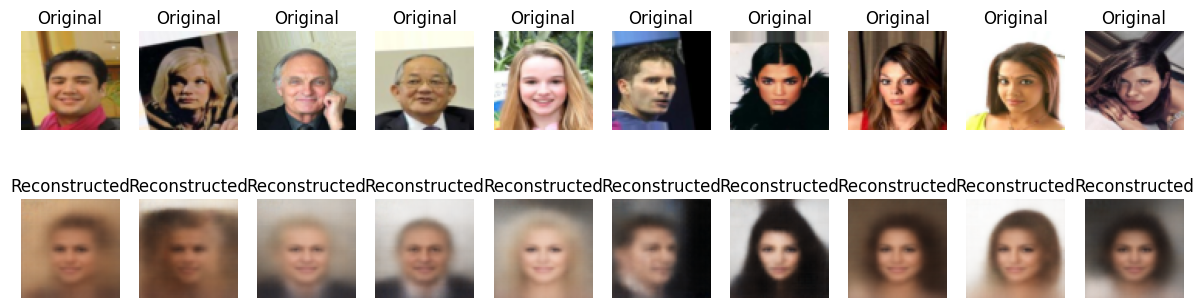

Validation Loss: 0.022156121579910183


In [13]:
validation_loss = validate_and_visualize_epoch(model, val_loader, device, num_images=10)

print(f"Validation Loss: {validation_loss}")

## Results Analysis:
-  Visualize the reconstructed images, latent space traversals, and loss curves. Discuss your findings.


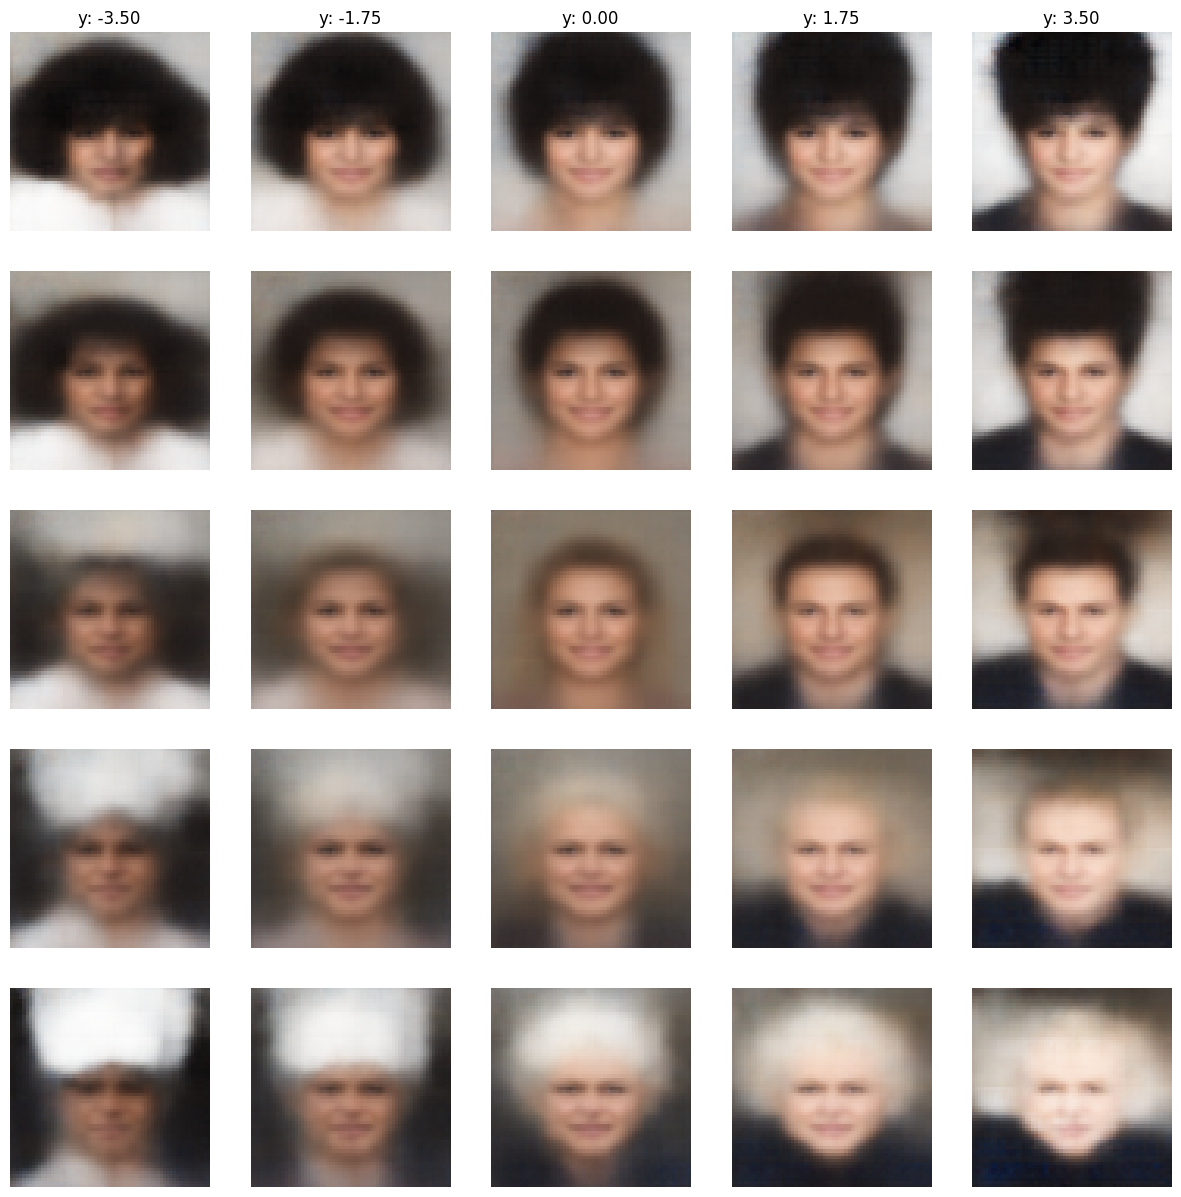

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
visualize_2d_latent_traversals(model, device, dim_range=3.5, num_samples=5, latent_dim=10, dims_to_traverse=(0, 1))


## Experimentation: 
- Experiment with different beta values and analyze their impact on the results.

In [ ]:
betas = [2,4,8,12]
for beta in betas:
    num_epochs = 5  # Define the number of epochs

    model = BetaVAE(in_channels=3, latent_dim=10,beta=beta).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss = validate_epoch(model, val_loader, device)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save model periodically or based on performance
        torch.save(model.state_dict(), 'beta_vae_checkpoint.pth')
    visualize_2d_latent_traversals(model, device, dim_range=3.5, num_samples=10, latent_dim=10, dims_to_traverse=(0, 1))
    validation_loss = validate_and_visualize_epoch(model, val_loader, device, num_images=10)
    print(f"Validation Loss: {validation_loss}")
    plot_loss_curves(train_loss, validation_loss)
